In [132]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap, cm, addcyclic
% matplotlib inline

In [133]:
import warnings
warnings.filterwarnings('ignore')

In [134]:
import seawater as sw
from ArcticTools import map

In [135]:
mesh=nc.Dataset('/ocean/xiaoxiny/research/data/mesh_mask_anha4_201509.nc')
e1t= mesh.variables['e1t'][0,400:,:]  # dx
e2t= mesh.variables['e2t'][0,400:,:]  # dy 
e3t= mesh.variables['e3t'][0,:,400:,:]
tmask= mesh.variables['tmask'][0,:,400:,:]
dep = mesh.variables['gdept_0'][0.,:]

bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]

In [136]:
dfield_dx = np.zeros((2,bathy.shape[0],bathy.shape[1]))
dfield_dx.shape

(2, 400, 544)

# Calculate dH

In [137]:
def gradient(Pressure):
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    This function calculate dP_dx, dP_dy
    '''
    dP = d_(Pressure);
    dx = e1t;
    dy = e2t;
    dP_x = dP[0,:]/dx;
    dP_y = dP[1,:]/dy;
    return dP_x, dP_y

def d_(field):
    '''    
    ug = -dP_y/(f*rho)
    vg = dP_x/(f*rho)
    In order to calculate dP_dx, dP_dy, we need dP. This function does this job.
    '''
    dfield= np.zeros((2,field.shape[0],field.shape[1]))
    # dx
    dfield[0,:, :-1] = field[:, 1:]-field[:, :-1]
    dfield[0,:,-1] = dfield[0,:,-2] # assuming the last two columns have the same dx (and dy)
    # dy
    dfield[1,:-1, :] = field[1:, :]-field[:-1, :]
    dfield[1,-1,:] = dfield[1,-2,:]
    return dfield

In [138]:
# calculate d(H)

dbathy= gradient(bathy)

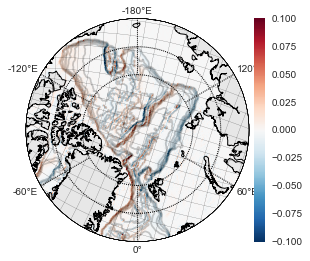

In [139]:
m,x,y = map.mapping(70)
m.pcolor(x,y,dbathy[0],cmap = 'RdBu_r',vmin=-0.1,vmax=0.1)  #dx
m.colorbar()

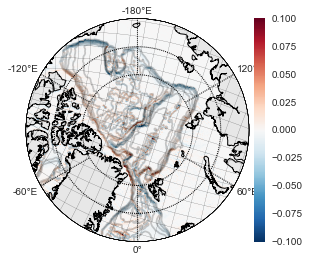

In [140]:
m,x,y = map.mapping(70)
m.pcolor(x,y,dbathy[1],cmap = 'RdBu_r',vmin=-0.1,vmax=0.1) #dy
m.colorbar()

In [141]:
def load_v(vel_comp,T, tmask, ENG, key ):
    '''
    This function is designed to obtain velocity field
    ======================================================
    '''
    vels ={'U':'vozocrtx','V':'vomecrty','W':'vovecrtz'}

    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*%s*%s.nc'%(ENG,vel_comp,T))[0])\
as temp:
        data  = temp.variables[vels[vel_comp]][0,:,400:,:]
        data [tmask == 0] = np.nan
    return data

In [142]:
def calulateT(year,ENG,layer):
    '''Calculate T = (u X (Delta H) in z direction)
    Input:
    year: calender year
    ENG: 'EXH001', EXH005','ENG3'
    layer: NEMO layer
    
    Output:
    result of T
    '''
    # load vel
    u= load_v('U',T=year,tmask= tmask, ENG=ENG, key = 'U')
    v= load_v('V',T=year,tmask= tmask, ENG=ENG, key = 'V')

    # arrange array in order
    totU= np.array((u[layer,:,:],v[layer,:,:]))
    totdH = np.array((dbathy[0],dbathy[1]))

    # allocation
    T = np.zeros_like(u[layer,:,:])

    # calculate cross product
    for i in range (totdH.shape[1]):
        for j in range (totdH.shape[2]):
            T[i,j] = np.float(-totU[1,i,j]*totdH[0,i,j] + totU[0,i,j]*totdH[1,i,j])* e1t[i,j] * e2t[i,j]
    # masked 9 and in valid numbers
    test = np.ma.masked_invalid(np.ma.masked_where(T==0,T))
    return test

# Calculate T = (u X (Delta H) in z direction)

In [143]:
dep[18]

55.764289104203272

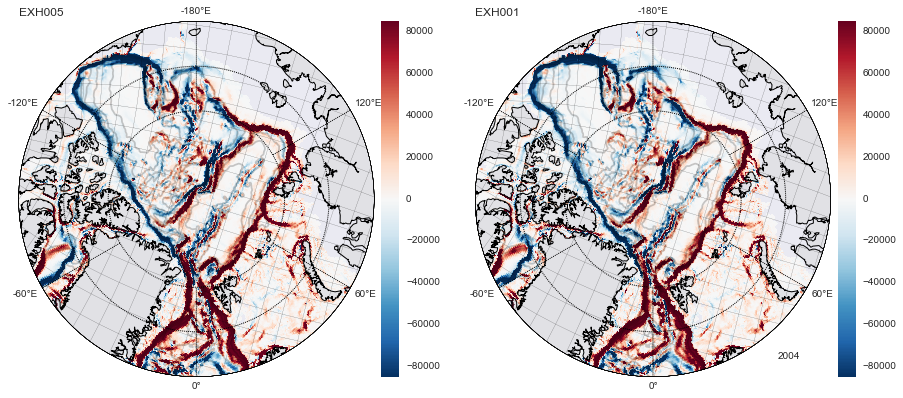

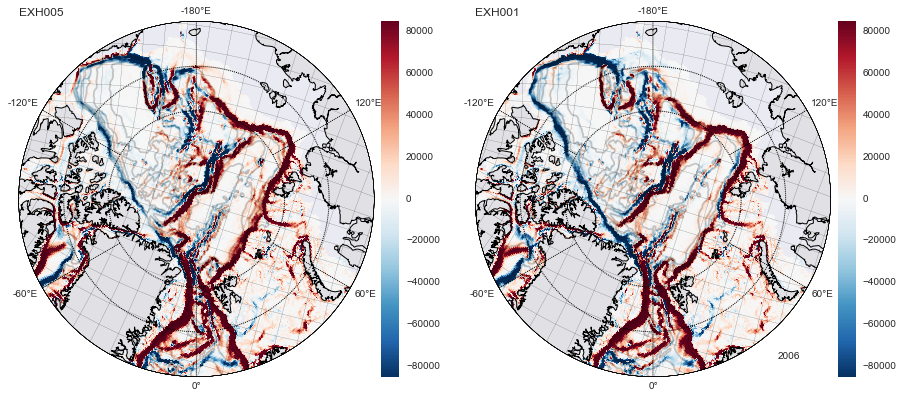

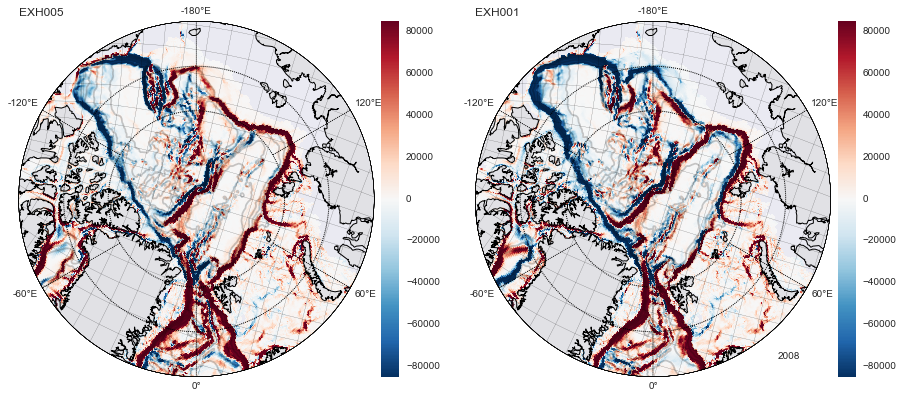

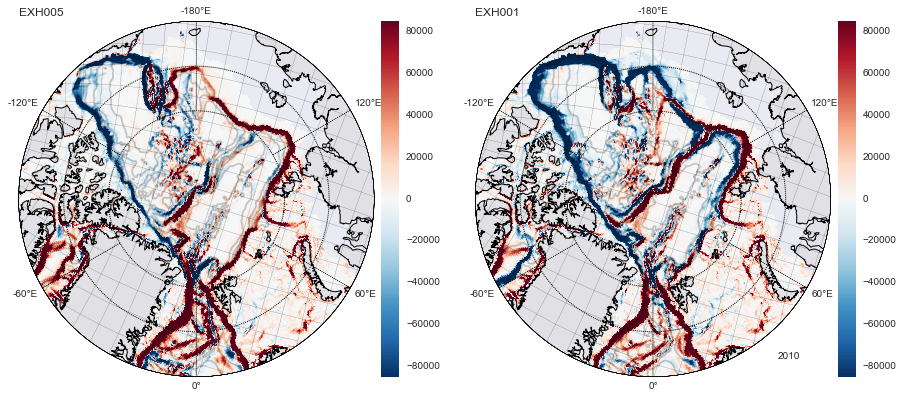

In [144]:
for i in range (2004,2011,2):
    test = calulateT(i,'EXH005',18)
    plt.figure(figsize=(15,10))
    ax=plt.subplot(121)
    m,x,y = map.mapping(70)
    m.pcolor(x,y,test,cmap = 'RdBu_r',vmin=-8.5e4,vmax=8.5e4) #dy
    m.colorbar()
    ax.set_title('EXH005',loc='left')
    
    ax = plt.subplot(122)
    test = calulateT(i,'EXH001',18)
    m,x,y = map.mapping(70)
    m.pcolor(x,y,test,cmap = 'RdBu_r',vmin=-8.5e4,vmax=8.5e4) #dy
    m.colorbar()
    ax.text(0.85,0.05,i,transform=ax.transAxes)
    ax.set_title('EXH001',loc='left')
    plt.show()

In [145]:
dep[35]

1062.4397212448976

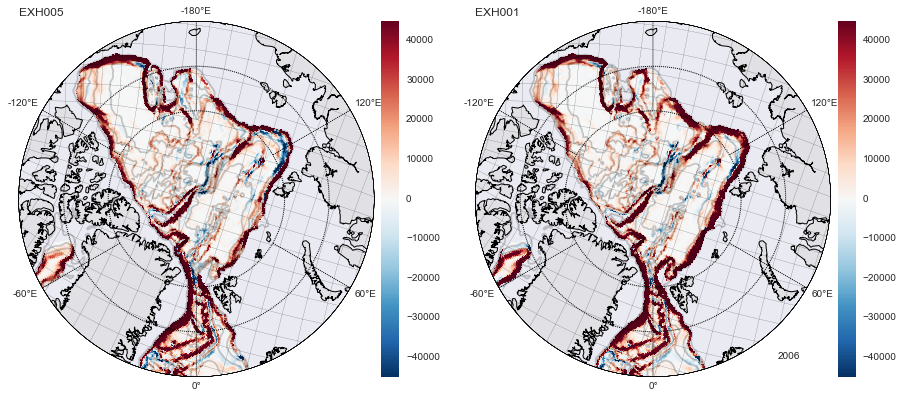

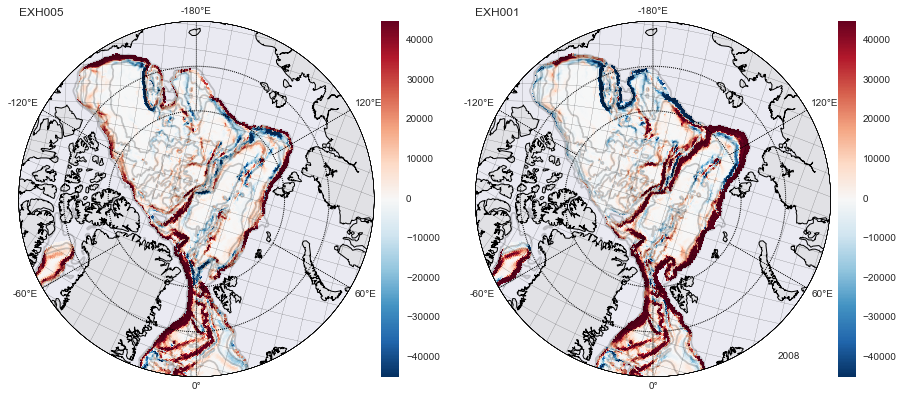

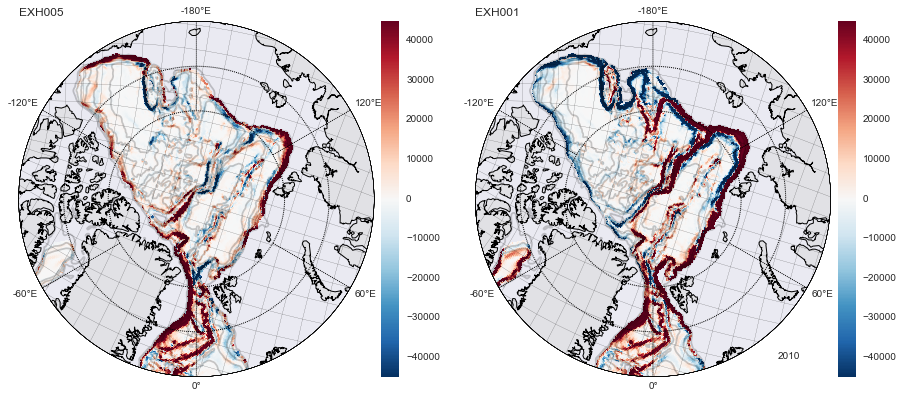

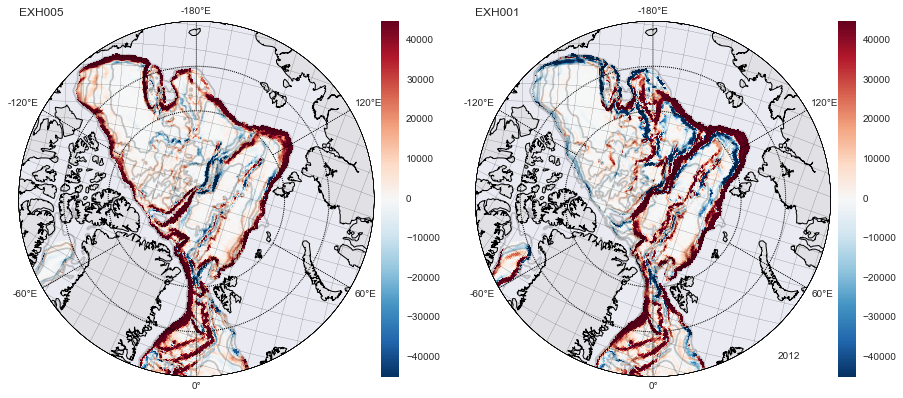

In [146]:
for i in range (2006,2014,2):
    test = calulateT(i,'EXH005',35)
    plt.figure(figsize=(15,10))
    ax=plt.subplot(121)
    m,x,y = map.mapping(70)
    m.pcolor(x,y,test,cmap = 'RdBu_r',vmin=-4.5e4,vmax=4.5e4) #dy
    m.colorbar()
    ax.set_title('EXH005',loc='left')
    
    ax = plt.subplot(122)
    test = calulateT(i,'EXH001',35)
    m,x,y = map.mapping(70)
    m.pcolor(x,y,test,cmap = 'RdBu_r',vmin=-4.5e4,vmax=4.5e4) #dy
    m.colorbar()
    ax.text(0.85,0.05,i,transform=ax.transAxes)
    ax.set_title('EXH001',loc='left')
    plt.show()

# Sum T in Canada Basin

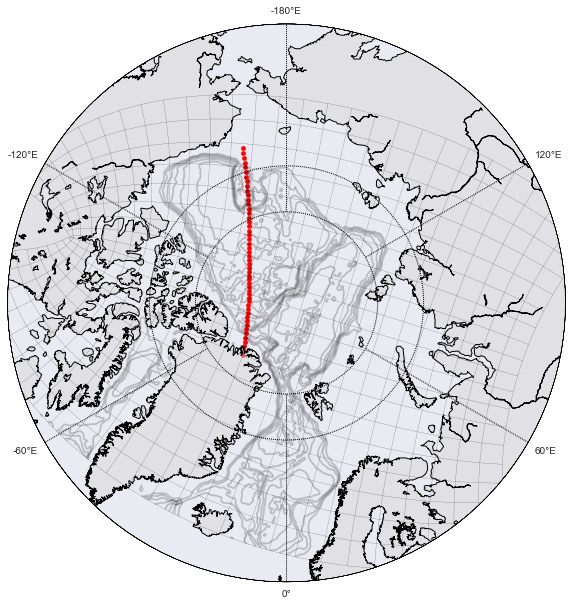

In [147]:
fig = plt.figure(figsize = (10,10))
m,x_lon,y_lat = map.mapping(60)

a= [400-260] 
b= [280]#195]  

for i in range (1,50):
    a.append(a[i-1]+4)
    b.append(b[i-1]-1)
m.scatter(x_lon[a,b],y_lat[a,b],color='r')

In [148]:
mymask = np.zeros_like(e1t[:,:])

for xnum in range (a[0],a[-1]):
    blim = int(-0.25*(xnum-150)+b[0])
    mymask[xnum,:blim] = 1

* test result

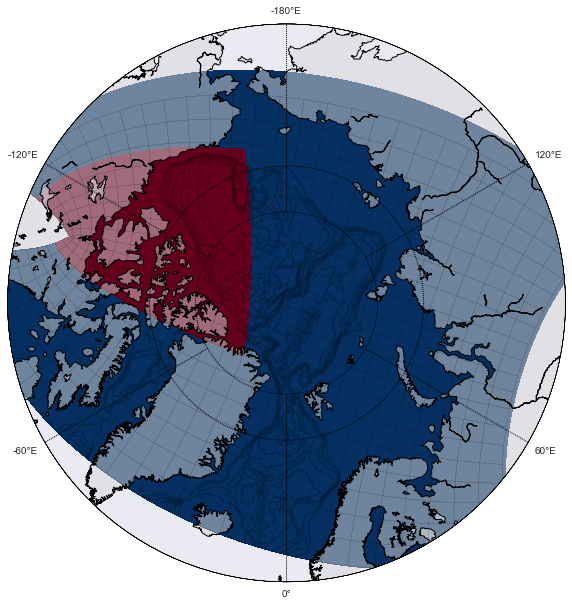

In [149]:
fig = plt.figure(figsize = (10,10))
m,x_lon,y_lat = map.mapping(60)

m.pcolor(x_lon,y_lat,mymask,cmap= 'RdBu_r')

In [150]:
def sumT(year,ENG,layer):
    '''Calculate T = (u X (Delta H) in z direction)
    Input:
    year: calender year
    ENG: 'EXH001', EXH005','ENG3'
    layer: NEMO layer
    
    Output:
    result of T
    '''
    # load vel
    u= load_v('U',T=year,tmask= tmask, ENG=ENG, key = 'U')
    v= load_v('V',T=year,tmask= tmask, ENG=ENG, key = 'V')

    # arrange array in order
    totU= np.array((u[layer,:,:],v[layer,:,:]))
    totdH = np.array((dbathy[0],dbathy[1]))

    # allocation
    T = np.zeros_like(u[layer,:,:])

    # calculate cross product
    for i in range (totdH.shape[1]):
        for j in range (totdH.shape[2]):
            T[i,j] = np.float(-totU[1,i,j]*totdH[0,i,j] + totU[0,i,j]*totdH[1,i,j])* e1t[i,j] * e2t[i,j]
    # masked 9 and in valid numbers
    test = np.ma.masked_invalid(np.ma.masked_where(T==0,T))
    test = np.sum(test*mymask)
    
    return test

* time series for sum T

In [151]:
Tsum=[]
time=[]
for i in range (2002,2014):
    test = sumT(i,'EXH001',35)
    Tsum.append(test)
    time.append(i)

In [152]:
Tsum30=[]
for i in range (2002,2014):
    test = sumT(i,'EXH001',30)
    Tsum30.append(test)

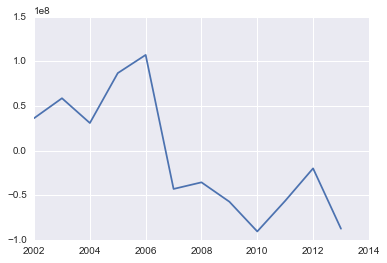

In [153]:
plt.plot(time,Tsum)

# location for calculating TPD

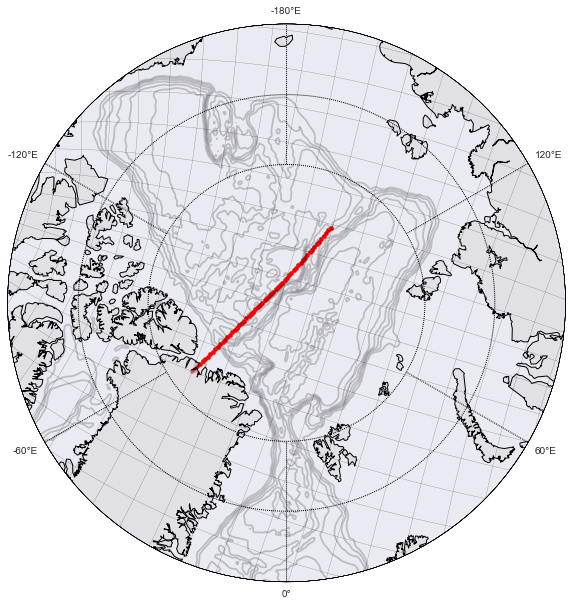

In [154]:
fig = plt.figure(figsize = (10,10))
m,x_lon,y_lat = map.mapping(70)

a= [-260] 
b= [260]

for i in range (1,60):
    a.append(a[i-1]+2)
    b.append(b[i-1]+1)
m.scatter(x_lon[a,b],y_lat[a,b],color='r')

# How does topostrophy change with depth
- EXH001

plt.figure(figsize=(10,3))
ax2 = plt.subplot(121)
ax2.plot(time,Tsum150,lw=2,label='Topostrophy at %sm'%int(dep[24]))
ax2.plot(time,Tsum500,lw=2,label='Topostrophy at %sm'%int(dep[30]))
ax2.plot(time,Tsum1000,lw=2,label='Topostrophy at %sm'%int(dep[35]))
ax2.plot(time,Tsum3000,lw=2,label='Topostrophy at %sm'%int(dep[42]),alpha=0.3)
plt.legend(loc=0)

ax2 = plt.subplot(122)
ax2.plot(time[1:],np.array(Tsum150[1:])-np.array(Tsum150[:-1]),lw=2,label='d(Topostrophy)/dt at %sm'%int(dep[24]))
ax2.plot(time[1:],np.array(Tsum500[1:])-np.array(Tsum500[:-1]),lw=2,label='d(Topostrophy)/dt at %sm'%int(dep[30]))
ax2.plot(time[1:],np.array(Tsum1000[1:])-np.array(Tsum1000[:-1]),lw=2,label='d(Topostrophy)/dt at %sm'%int(dep[35]))
ax2.plot(time[1:],np.array(Tsum3000[1:])-np.array(Tsum3000[:-1]),lw=2,label='d(Topostrophy)/dt at %sm'%int(dep[42]),alpha=0.3)
plt.legend(loc=0)
plt.show()

- EXH005

plt.figure(figsize=(10,3))
ax2 = plt.subplot(121)
ax2.plot(time,Tsum150EXH005,lw=2,label='Topostrophy at %sm'%int(dep[24]))
ax2.plot(time,Tsum500EXH005,lw=2,label='Topostrophy at %sm'%int(dep[30]))
ax2.plot(time,Tsum1000EXH005,lw=2,label='Topostrophy at %sm'%int(dep[35]))
ax2.plot(time,Tsum3000EXH005,lw=2,label='Topostrophy at %sm'%int(dep[42]),alpha=0.3)
plt.legend(loc=0)

#ax2 = plt.subplot(122)
#ax2.plot(time[1:],np.array(Tsum150EXH005[1:])-np.array(Tsum150EXH005[:-1]),lw=2,label='d(Topostrophy)/dt at %sm'%int(dep[24]))
#ax2.plot(time[1:],np.array(Tsum500EXH005[1:])-np.array(Tsum500EXH005[:-1]),lw=2,label='d(Topostrophy)/dt at %sm'%int(dep[30]))
#ax2.plot(time[1:],np.array(Tsum1000EXH005[1:])-np.array(Tsum1000EXH005[:-1]),lw=2,label='d(Topostrophy)/dt at %sm'%int(dep[35]))
#ax2.plot(time[1:],np.array(Tsum3000EXH005[1:])-np.array(Tsum3000EXH005[:-1]),lw=2,label='d(Topostrophy)/dt at %sm'%int(dep[42]),alpha=0.3)
#plt.legend(loc=0)
plt.show()

# How does topostrophy repsond to TDP

Why does the increase (by saying increase, I mean more negative) in TDP leads to decrease in topostrophy?

* EXH001 

(two-year lag)

In [155]:
layer=24
FluxEXH001=[]
for year in range (2002,2014):
    v= load_v('V',T=year,tmask= tmask, ENG='EXH001', key = 'V')
    u= load_v('U',T=year,tmask= tmask, ENG='EXH001', key = 'U')
    
    z= (1.5**2+1**2)**0.5
    
    rotav = v * 1/z+ u * 2/z 
    dsec  = ((e2t * 2)**2 + (e1t * 1)**2)**0.5
    flux = 0
    for num in range(layer):
        flux += rotav[num,a,b] * dsec[a,b] *e3t[num,a,b]
    flux[flux > 0] = np.nan
    FluxEXH001.append(flux)

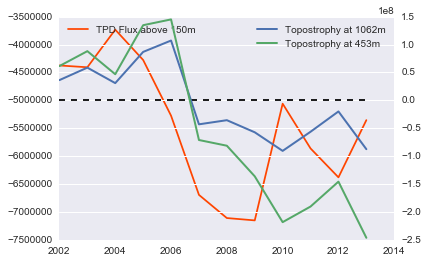

In [156]:
# plot
fig, ax1 = plt.subplots()
ax1.plot(time,np.nansum(np.array(FluxEXH001),axis=1),c='orangered',label='TPD Flux above 150m') 
ax1.legend(loc=2)
ax1.grid(False)

ax2 = ax1.twinx()        
ax2.plot(time,Tsum,lw=2,label='Topostrophy at %sm'%int(dep[35]))
ax2.plot(time,Tsum30,lw=2,label='Topostrophy at %sm'%int(dep[30]))
ax2.hlines(y=0,xmin=np.min(time),xmax=np.max(time),linestyles='--')
ax2.legend()

0.838501821212 [ 0.00474121]


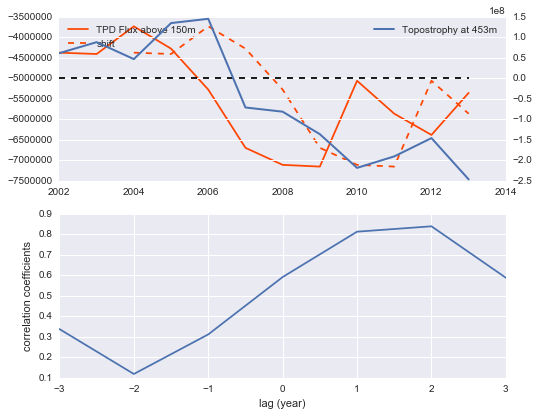

In [157]:
from scipy.stats.stats import pearsonr 
#The p-value roughly indicates the probability of an uncorrelated system
#producing datasets that have a Pearson correlation at least as extreme
#as the one computed from these datasets. The p-values are not entirely
#reliable but are probably reasonable for datasets larger than 500 or so.


a= np.nansum(np.array(FluxEXH001),axis=1)
v= Tsum30

cc=[]
p =[]
lag=[]
for i in range (3,-1,-1):
    a_slice=a[:9]
    v_slice=v[i:i+9]
    cc.append(pearsonr(a_slice,v_slice)[0])
    p.append(pearsonr(a_slice,v_slice)[1])
    lag.append(i)
    
for i in range (1,4):
    a_slice=a[i:i+9]
    v_slice=v[:9]
    i= 0-i
    cc.append(pearsonr(a_slice,v_slice)[0])
    p.append(pearsonr(a_slice,v_slice)[1])
    lag.append(i)


    
    
fig = plt.figure(figsize=(8,10))
ax1 = plt.subplot(311)
ax1.plot(time,np.nansum(np.array(FluxEXH001),axis=1),c='orangered',label='TPD Flux above 150m')
ax1.plot(np.array(time[:-2])+2,np.nansum(np.array(FluxEXH001),axis=1)[:-2],'--',c='orangered',label='shift') 
ax1.legend(loc=2)
ax1.grid(False)

ax2 = ax1.twinx()        
ax2.plot(time,Tsum30,lw=2,label='Topostrophy at %sm'%int(dep[30]))
ax2.hlines(y=0,xmin=np.min(time),xmax=np.max(time),linestyles='--')
ax2.legend()

ax1 = plt.subplot(312)
plt.plot(lag,abs(np.array(cc)))
plt.xlabel('lag (year)')
plt.ylabel('correlation coefficients')
print (np.max(cc),np.array(p)[cc == np.max(cc)])

* EXH005

In [160]:

a= [-260] 
b= [260]

for i in range (1,60):
    a.append(a[i-1]+2)
    b.append(b[i-1]+1)

FluxEXH005=[]
for year in range (2002,2014):
    v= load_v('V',T=year,tmask= tmask, ENG='EXH005', key = 'V')
    u= load_v('U',T=year,tmask= tmask, ENG='EXH005', key = 'U')
    
    z= (1.5**2+1**2)**0.5
    
    rotav = v * 1/z+ u * 2/z 
    dsec  = ((e2t * 2)**2 + (e1t * 1)**2)**0.5
    flux = 0
    for num in range(layer):
        flux += rotav[num,a,b] * dsec[a,b] *e3t[num,a,b]
    flux[flux > 0] = np.nan
    FluxEXH005.append(flux)

In [161]:
Tsum500=[]
for i in range (2002,2014):
    test = sumT(i,'EXH005',30)
    Tsum500.append(test)
Tsum1000=[]
for i in range (2002,2014):
    test = sumT(i,'EXH005',35)
    Tsum1000.append(test)

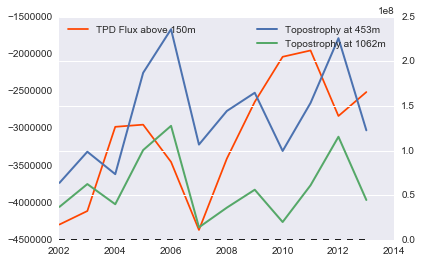

In [162]:
# plot
fig, ax1 = plt.subplots()
ax1.plot(time,np.nansum(np.array(FluxEXH005),axis=1),c='orangered',label='TPD Flux above 150m') 
ax1.legend(loc=2)
ax1.grid(False)

ax2 = ax1.twinx()        
ax2.plot(time,Tsum500,lw=2,label='Topostrophy at %sm'%int(dep[30]))
ax2.plot(time,Tsum1000,lw=2,label='Topostrophy at %sm'%int(dep[35]))
ax2.hlines(y=0,xmin=np.min(time),xmax=np.max(time),linestyles='--')
ax2.legend()

- Which one is responsible for the change in EXH001? Short term variation or **long term variation** ?

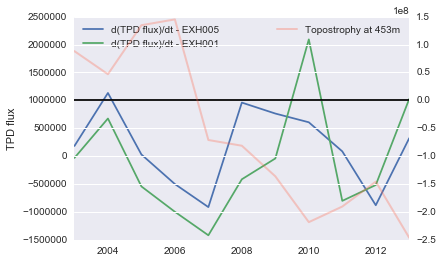

In [163]:
fig, ax1 = plt.subplots()
EXH005TPD = np.nansum(np.array(FluxEXH005),axis=1)
EXH001TPD = np.nansum(np.array(FluxEXH001),axis=1)
ax1.plot(time[1:],EXH005TPD[1:]-EXH005TPD[:-1],label='d(TPD flux)/dt - EXH005') 
ax1.plot(time[1:],EXH001TPD[1:]-EXH001TPD[:-1],label='d(TPD flux)/dt - EXH001') 
ax1.set_ylabel('TPD flux')
ax1.grid(False)
plt.legend(loc=0)


ax2 = ax1.twinx()        
ax2.plot(time,Tsum30,c='tomato',lw=2,label='Topostrophy at %sm'%int(dep[30]),alpha=0.3)
ax2.hlines(y=0,xmin=np.min(time),xmax=np.max(time),linestyles='-')
plt.xlim(2003,2013)
plt.legend(loc=0)


Haven't figure out:

Where does the short/long term variation comes from in the model? (climatology? But they share the same atmosphere forcing file..)

[We see similar correlation between AWI and topostrphy. How do we know which one is more important? AWI inflow or TPD? (AO?) ](#cell2)


# How does the line respond to inflow

In [164]:
def vel(keyword,T,ENG):
    'design to obtain velocity field'
    if keyword =='U':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s*.nc'%(ENG,T)))
        uvel=nc.Dataset(nc_filename[0])        
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s*.nc'%(ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

def flux(u,v,e1t=e1t, e2t=e2t, e3t=e3t, tmask=tmask):
    '''    
    flux_x = u * dy * dz
    flux_y = v * dx * dz
    '''
    flux_xy= {'flux_x': np.zeros((e3t.shape[0],e1t.shape[0],e1t.shape[1]))\
             ,'flux_y': np.zeros((e3t.shape[0],e1t.shape[0],e1t.shape[1]))}  
    
    dx = e1t;
    dy = e2t;
    dz = e3t;
    
    for num in range (dz.shape[0]):
        flux_xy['flux_x'][num,...] = u[num,...]*dy*dz[num,...];
        flux_xy['flux_y'][num,...] = v[num,...]*dx*dz[num,...];

        
    return flux_xy

def main_flux(yearnum,startyear,ENG):
    
    Fram_influx=[]
    Bsea_influx=[]
    year=[]
    a=[];b=[]
    
    
    for time in range (yearnum):

        # loading vel
        u =vel('U',time+startyear,ENG)
        v =vel('V',time+startyear,ENG)
      
        # calculating flux - before rotation
        flux_b = flux(u,v)
        
        # Fram strait, roate, from grid to along/across section
                            
        cr_flux = flux_b['flux_y'][:,-265,305:335] 
        al_flux = flux_b['flux_x'][:,-265,305:335]
     
        influx =np.ma.masked_where(cr_flux<=0,cr_flux)
        Fram_influx.append(np.sum(np.ma.masked_invalid(influx)))
        
        al_flux = flux_b['flux_y'][:,-265:-160,385] 
        cr_flux = flux_b['flux_x'][:,-265:-160,385]
        influx =np.ma.masked_where(cr_flux<0,cr_flux)
        Bsea_influx.append(np.sum((influx)))
        
        year.append(time+startyear)

    return np.array(Fram_influx), np.array(Bsea_influx), np.array(year)

In [165]:
Fram_influx, Bsea_influx, year=\
main_flux(yearnum=13,startyear=2002,ENG='EXH001')

In [166]:
Tsum150=[]
for i in range (2002,2014):
    test = sumT(i,'EXH001',24)
    Tsum150.append(test)

In [167]:
Tsum500=[]
for i in range (2002,2014):
    test = sumT(i,'EXH001',30)
    Tsum500.append(test)
Tsum1000=[]
for i in range (2002,2014):
    test = sumT(i,'EXH001',35)
    Tsum1000.append(test)

In [168]:
Tsum3000=[]
for i in range (2002,2014):
    test = sumT(i,'EXH001',42)
    Tsum3000.append(test)

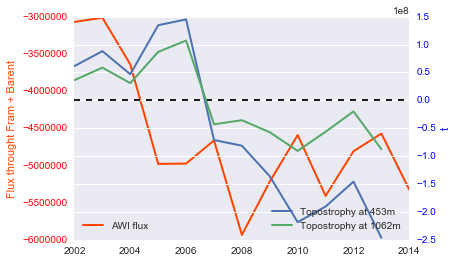

In [169]:
fig, ax1 = plt.subplots()

ax1.plot(year,-(Fram_influx[:]+Bsea_influx[:]),'orangered',\
         lw=2,label='AWI flux')
ax1.set_ylabel('Flux throught Fram + Barent' , color='orangered')
for tl in ax1.get_yticklabels():
    tl.set_color('red')
ax1.legend(loc=3)
ax1.grid(False)
    #plt.ylim(3.2e6,7e6)

ax2 = ax1.twinx()
ax2.plot(time,Tsum500,lw=2,label='Topostrophy at %sm'%int(dep[30]))
ax2.plot(time,Tsum1000,lw=2,label='Topostrophy at %sm'%int(dep[35]))
ax2.set_ylabel('t', color='blue')
for tl in ax2.get_yticklabels():
    tl.set_color('blue')
plt.legend(loc=4)
plt.xlim(np.min(year),np.max(year))
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
#plt.ylim(-0.03,0.06)
plt.show()

In [170]:
time

[2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]

0.895387751113 [ 0.00109915]


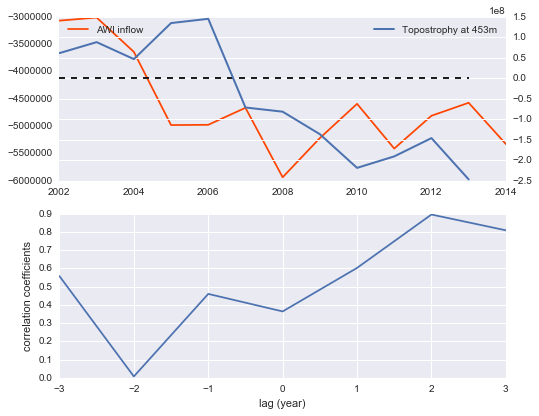

In [171]:
from scipy.stats.stats import pearsonr 
#The p-value roughly indicates the probability of an uncorrelated system
#producing datasets that have a Pearson correlation at least as extreme
#as the one computed from these datasets. The p-values are not entirely
#reliable but are probably reasonable for datasets larger than 500 or so.


a= -(Fram_influx[:]+Bsea_influx[:])
v= Tsum500

cc=[]
p =[]
lag=[]
for i in range (3,-1,-1):
    a_slice=a[:9]
    v_slice=v[i:i+9]
    cc.append(pearsonr(a_slice,v_slice)[0])
    p.append(pearsonr(a_slice,v_slice)[1])
    lag.append(i)
    
for i in range (1,4):
    a_slice=a[i:i+9]
    v_slice=v[:9]
    i= 0-i
    cc.append(pearsonr(a_slice,v_slice)[0])
    p.append(pearsonr(a_slice,v_slice)[1])
    lag.append(i)

cc=np.array(cc)    
fig = plt.figure(figsize=(8,10))
ax1 = plt.subplot(311)
ax1.plot(year,-(Fram_influx[:]+Bsea_influx[:]),c='orangered',label='AWI inflow')
ax1.legend(loc=2)
ax1.grid(False)

ax2 = ax1.twinx()        
ax2.plot(time,Tsum30,lw=2,label='Topostrophy at %sm'%int(dep[30]))
ax2.hlines(y=0,xmin=np.min(time),xmax=np.max(time),linestyles='--')
ax2.legend()

ax1 = plt.subplot(312)
plt.plot(lag,abs(np.array(cc)))
plt.xlabel('lag (year)')
plt.ylabel('correlation coefficients')
print (np.max(abs(cc)),np.array(p)[abs(cc) == np.max(abs(cc))])

In [172]:
Fram_influxEXH005, Bsea_influxEXH005, year=\
main_flux(yearnum=13,startyear=2002,ENG='EXH005')

In [173]:
Tsum500EXH005=[]
for i in range (2002,2014):
    test = sumT(i,'EXH005',30)
    Tsum500EXH005.append(test)
Tsum1000EXH005=[]
for i in range (2002,2014):
    test = sumT(i,'EXH005',35)
    Tsum1000EXH005.append(test)
    
Tsum150EXH005=[]
for i in range (2002,2014):
    test = sumT(i,'EXH005',24)
    Tsum150EXH005.append(test)
    
Tsum3000EXH005=[]
for i in range (2002,2014):
    test = sumT(i,'EXH005',42)
    Tsum3000EXH005.append(test)

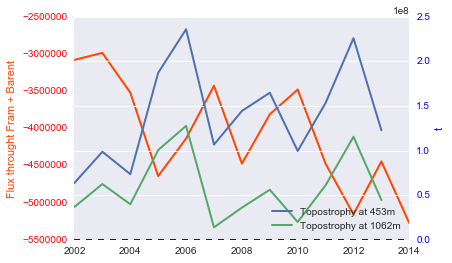

In [174]:
fig, ax1 = plt.subplots()

ax1.plot(year,-(Fram_influxEXH005[:]+Bsea_influxEXH005[:]),'orangered',\
         lw=2,label='AWI flux')
ax1.set_ylabel('Flux throught Fram + Barent' , color='orangered')
for tl in ax1.get_yticklabels():
    tl.set_color('red')
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(time,Tsum500EXH005,lw=2,label='Topostrophy at %sm'%int(dep[30]))
ax2.plot(time,Tsum1000EXH005,lw=2,label='Topostrophy at %sm'%int(dep[35]))
ax2.set_ylabel('t', color='blue')
for tl in ax2.get_yticklabels():
    tl.set_color('blue')
plt.legend(loc=4)
plt.xlim(np.min(year),np.max(year))
ax2.hlines(y=0,xmin=np.min(year),xmax=np.max(year),linestyles='--')
plt.show()

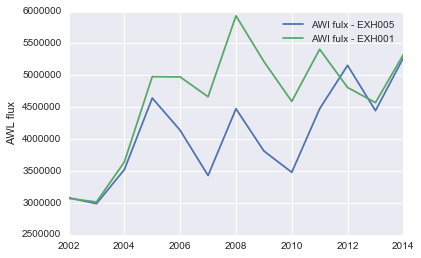

In [175]:
fig, ax1 = plt.subplots()
ax1.plot(year,np.array(Fram_influxEXH005[:]+Bsea_influxEXH005[:]),label='AWI fulx - EXH005') 
ax1.plot(year,np.array(Fram_influx[:]+Bsea_influx[:]),label='AWI fulx - EXH001') 
ax1.set_ylabel('AWL flux')
ax1.legend(loc=0)

In [176]:
# put them togerther

# TPD & AWI

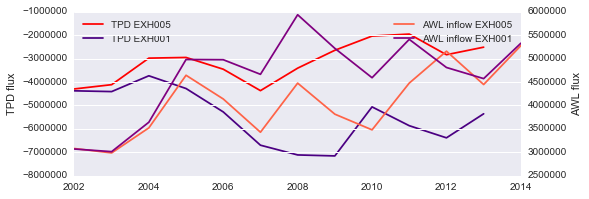

In [177]:
fig = plt.figure(figsize=(8,10))
ax1 = plt.subplot(311)
ax1.plot(time,np.nansum(np.array(FluxEXH005),axis=1),label='TPD EXH005',c='red') 
ax1.plot(time,np.nansum(np.array(FluxEXH001),axis=1),label='TPD EXH001',c='indigo') 
ax1.set_ylabel('TPD flux')
ax1.legend(loc=2)
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(year,np.array(Fram_influxEXH005[:]+Bsea_influxEXH005[:]),c='tomato',label='AWL inflow EXH005') 
ax2.plot(year,np.array(Fram_influx[:]+Bsea_influx[:]),c='purple',label='AWL inflow EXH001') 
ax2.set_ylabel('AWL flux')
ax2.legend(loc=1)


# T with TPD and AWL  <a id="cell2"></a>

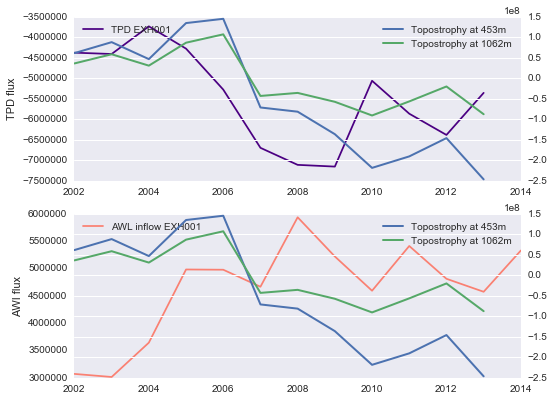

In [178]:
fig = plt.figure(figsize=(8,10))
ax1 = plt.subplot(311)
ax1.plot(time,np.nansum(np.array(FluxEXH001),axis=1),label='TPD EXH001',c='indigo') 
ax1.set_ylabel('TPD flux')
ax1.legend(loc=2)
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(time,Tsum500,lw=2,label='Topostrophy at %sm'%int(dep[30]))
ax2.plot(time,Tsum1000,lw=2,label='Topostrophy at %sm'%int(dep[35]))
ax2.legend(loc=1)



ax1 = plt.subplot(312)
ax1.plot(year,np.array(Fram_influx[:]+Bsea_influx[:]),c='salmon',label='AWL inflow EXH001') 
ax1.set_ylabel('AWI flux')
ax1.legend(loc=2)
ax1.grid(False)

ax2 = ax1.twinx()
ax2.plot(time,Tsum500,lw=2,label='Topostrophy at %sm'%int(dep[30]))
ax2.plot(time,Tsum1000,lw=2,label='Topostrophy at %sm'%int(dep[35]))
ax2.legend(loc=1)

draft to explore relation between AWI and TPD

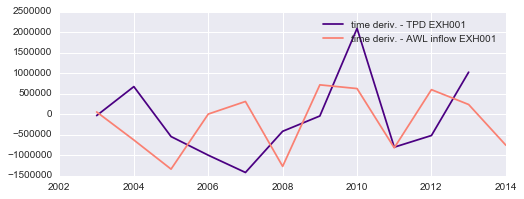

In [179]:
fig = plt.figure(figsize=(8,10))
ax1 = plt.subplot(311)
tempTPD= np.nansum(np.array(FluxEXH001),axis=1)
ax1.plot(time[1:],tempTPD[1:]-tempTPD[:-1],label='time deriv. - TPD EXH001',c='indigo') 
ax1.legend(loc=2)


tempflux=-np.array(Fram_influx[:]+Bsea_influx[:])
ax1.plot(year[1:],tempflux[1:]-tempflux[:-1],c='salmon',label='time deriv. - AWL inflow EXH001') 
ax1.legend(loc=1)


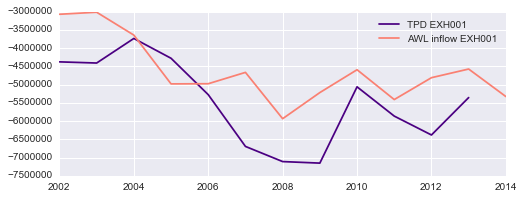

In [180]:
fig = plt.figure(figsize=(8,10))
ax1 = plt.subplot(311)
ax1.plot(time,tempTPD,label='TPD EXH001',c='indigo') 
ax1.legend(loc=2)

ax1.plot(year,tempflux,c='salmon',label='AWL inflow EXH001') 
ax1.legend(loc=1)

(-0.55759491204722089, 0.11878420694378036)
0.789849247103 0.422525222663


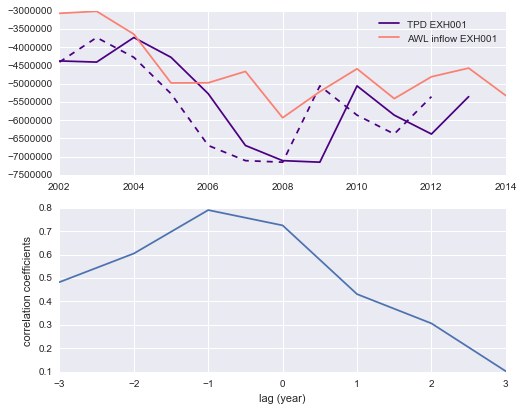

In [181]:
from scipy.stats.stats import pearsonr 
#The p-value roughly indicates the probability of an uncorrelated system
#producing datasets that have a Pearson correlation at least as extreme
#as the one computed from these datasets. The p-values are not entirely
#reliable but are probably reasonable for datasets larger than 500 or so.


a= tempTPD
v= tempflux[:-1]
print (pearsonr(a_slice,v_slice))

cc=[]
p =[]
lag=[]
for i in range (3,-1,-1):
    a_slice=a[:9]
    v_slice=v[i:i+9]
    cc.append(pearsonr(a_slice,v_slice)[0])
    p.append(pearsonr(a_slice,v_slice)[1])
    lag.append(i)
    
for i in range (1,4):
    a_slice=a[i:i+9]
    v_slice=v[:9]
    i= 0-i
    cc.append(pearsonr(a_slice,v_slice)[0])
    p.append(pearsonr(a_slice,v_slice)[1])
    lag.append(i)

    
    
    
    
fig = plt.figure(figsize=(8,10))
ax1 = plt.subplot(311)
ax1.plot(time,tempTPD,label='TPD EXH001',c='indigo') 
ax1.plot(time[:-1],tempTPD[1:],'--',c='indigo') 
ax1.legend(loc=2)
ax1.plot(year,tempflux,c='salmon',label='AWL inflow EXH001') 
ax1.legend(loc=1)

ax1 = plt.subplot(312)
plt.plot(lag,abs(np.array(cc)))
plt.xlabel('lag (year)')
plt.ylabel('correlation coefficients')
print (np.max(cc),p[1])

In [182]:
# change in AWl leads to changes in TPD??

## relationship with sea-surface height

In [183]:
model = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_ssh_year2010.nc')
ssh = model.variables['sossheig'][0,400:,:]

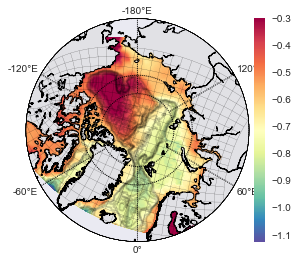

In [184]:
m,x_lon,y_lat=map.mapping(60)
m.pcolor(x_lon,y_lat,ssh,cmap='Spectral_r',vmax=-0.3)
m.colorbar()

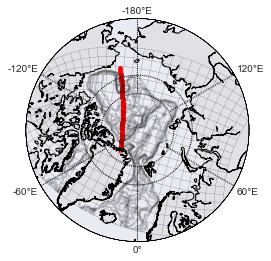

In [185]:
m,x_lon,y_lat = map.mapping(60)

a= [400-260] 
b= [280]#195]  

for i in range (1,50):
    a.append(a[i-1]+4)
    b.append(b[i-1]-1)
m.scatter(x_lon[a,b],y_lat[a,b],color='r')

In [186]:
myCBh = np.zeros_like(e1t[:,:])

for xnum in range (a[0],a[-1]):
    blim = int(-0.25*(xnum-150)+b[0])
    myCBh[xnum,:blim] = 1

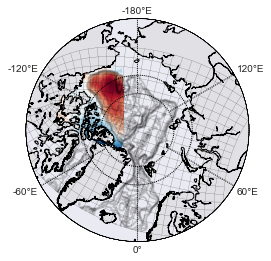

In [187]:
CBh=myCBh*ssh
CBh [CBh == 0] = np.nan

m,x_lon,y_lat = map.mapping(60)
m.pcolor(x_lon,y_lat,np.ma.masked_invalid(CBh),cmap= 'RdBu_r')

In [188]:
myCBl = np.zeros_like(e1t[:,:])

for xnum in range (a[0],a[-1]):
    blim = int(-0.25*(xnum-150)+b[0])
    myCBl[xnum,blim:450] = 1

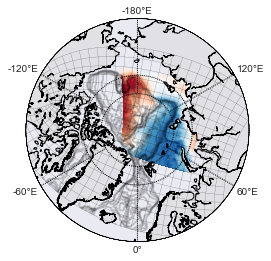

In [189]:
CBl=myCBl*ssh
CBl [CBl == 0] = np.nan

m,x_lon,y_lat = map.mapping(60)
m.pcolor(x_lon,y_lat,np.ma.masked_invalid(CBl),cmap= 'RdBu_r')

In [190]:
def CBh_timeseries():
    cbh_ts=[]
    for i in range (2002,2014):
        model = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_ssh_year%s.nc'%(i))
        ssh = model.variables['sossheig'][0,400:,:]
        a= [400-260] 
        b= [280]#195]  

        for i in range (1,50):
            a.append(a[i-1]+4)
            b.append(b[i-1]-1)
        myCBh = np.zeros_like(e1t[:,:])

        for xnum in range (a[0],a[-1]):
            blim = int(-0.25*(xnum-150)+b[0])
            myCBh[xnum,:blim] = 1
        CBh=myCBh*ssh
        CBh [CBh == 0] = np.nan
        cbh_ts.append(np.nanmean(CBh))
    return np.array(cbh_ts)

In [191]:
def CBl_timeseries():
    cbl_ts=[]
    for i in range (2002,2014):
        model = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_ssh_year%s.nc'%(i))
        ssh = model.variables['sossheig'][0,400:,:]
        a= [400-260] 
        b= [280]#195]  

        for i in range (1,50):
            a.append(a[i-1]+4)
            b.append(b[i-1]-1)
        myCBl = np.zeros_like(e1t[:,:])

        for xnum in range (a[0],a[-1]):
            blim = int(-0.25*(xnum-150)+b[0])
            myCBl[xnum,blim:450] = 1
        CBl=myCBl*ssh
        CBl [CBl == 0] = np.nan
        cbl_ts.append(np.nanmean(CBl))
    return np.array(cbl_ts)

In [192]:
cbh_ts = CBh_timeseries()

In [193]:
cbl_ts = CBl_timeseries()

(0.48253184776084185, 0.18831047042070156)
0.939367806464 [ 0.00017026]


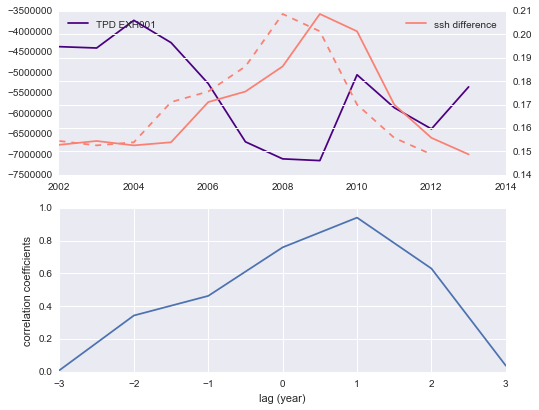

In [194]:
from scipy.stats.stats import pearsonr 
#The p-value roughly indicates the probability of an uncorrelated system
#producing datasets that have a Pearson correlation at least as extreme
#as the one computed from these datasets. The p-values are not entirely
#reliable but are probably reasonable for datasets larger than 500 or so.


a= tempTPD
v= cbh_ts-cbl_ts
print (pearsonr(a_slice,v_slice))

cc=[]
p =[]
lag=[]
for i in range (3,-1,-1):
    a_slice=a[:9]
    v_slice=v[i:i+9]
    cc.append(pearsonr(a_slice,v_slice)[0])
    p.append(pearsonr(a_slice,v_slice)[1])
    lag.append(i)
    
for i in range (1,4):
    a_slice=a[i:i+9]
    v_slice=v[:9]
    i= 0-i
    cc.append(pearsonr(a_slice,v_slice)[0])
    p.append(pearsonr(a_slice,v_slice)[1])
    lag.append(i)

    
    
    
    
fig = plt.figure(figsize=(8,10))
ax1 = plt.subplot(311)
ax1.plot(time,tempTPD,label='TPD EXH001',c='indigo') 

ax1.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(time,cbh_ts-cbl_ts,c='salmon',label='ssh difference')
ax2.plot(time[:-1],(cbh_ts-cbl_ts)[1:],'--',c='salmon') 
ax2.legend(loc=1)
ax1.grid(False)

cc=np.array(cc)
ax1 = plt.subplot(312)
plt.plot(lag,abs(np.array(cc)))
plt.xlabel('lag (year)')
plt.ylabel('correlation coefficients')
print (np.max(abs(cc)),np.array(p)[abs(cc) == np.max(abs(cc))])